# Generare le istanze

Prima assicurati di avere tutti i pachetti necessari installati. Se non hai installato i pacchetti, esegui il comando seguente: 
```bash
pip3 install -r requirements.txt
```

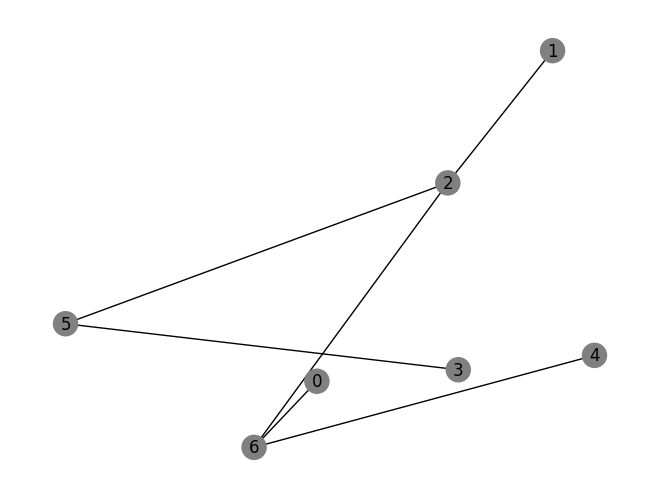

Number of edges:  6
Weight of the edges of the tree:  {(0, 6): 25.942243542145693, (1, 2): 50.15974481593781, (2, 5): 87.92041856133307, (2, 6): 99.16148445843275, (3, 5): 76.68767828015137, (4, 6): 72.44998274671983}
Number of nodes:  7
Number of flows:  3
Flows with their source and destination: [[0, 2], [4, 5], [5, 0]]


In [1]:
import networkx as nx
import utility_functions as uf

# CREATING A TREE NETWORK AND SAVING IT TO A .gml FILE

T, flows = uf.generate_random_network_tree(7, 3, 150)
uf.draw_tree(T)

nx.write_gml(T, "tree_net/tree.gml")

print("Number of edges: ", T.number_of_edges())
print("Weight of the edges of the tree: ", uf.get_weight_of_edges(T))
print("Number of nodes: ", T.number_of_nodes())
print("Number of flows: ", T.graph['K'])
print("Flows with their source and destination:", flows)

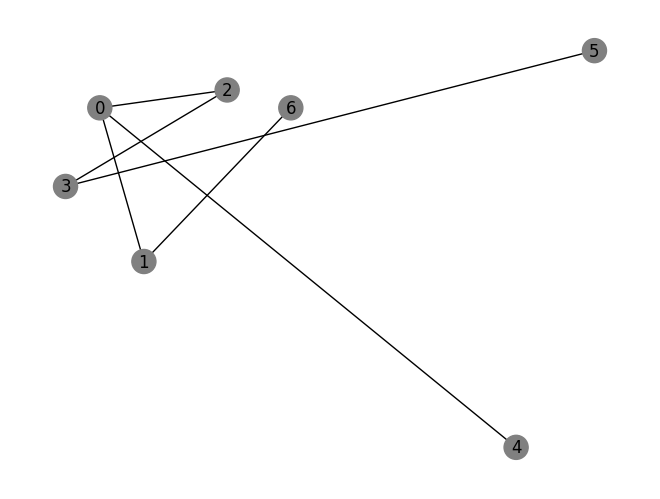

In [13]:
# READING THE TREE NETWORK FROM THE .gml FILE 

T = nx.read_gml("tree_net/tree.gml")
uf.draw_tree(T)